In [85]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display
import sympy

**Lectura de la señal**

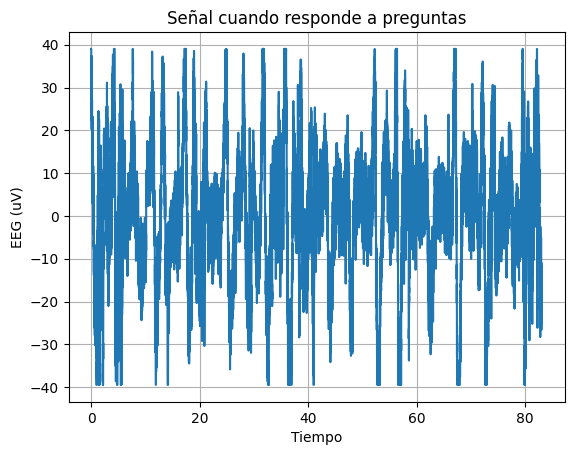

In [86]:

# Nombre del archivo de texto
#archivo = "/content/CesarBase.txt"
#archivo = "/content/cesar_pesta.txt"
archivo = "/content/cesar_preguntas.txt"

# Leer los datos del archivo y omitir las primeras 7 líneas
datos = np.loadtxt(archivo, skiprows=7)

# Extraer la columna de interés (columna 6)
senal = datos[:, 5]

num_muestra = np.arange(len(senal))
# Ganancia = 41782
senalV = (((senal/1024)-1/2)*3.3)/41782
senaluV = senalV*1000000
Fs = 1000 #frecuencia de muestreo
t = num_muestra/Fs
# Trazar la señal
plt.plot(num_muestra/1000, senaluV)
plt.xlabel('Tiempo')
plt.ylabel('EEG (uV)')
#plt.xlim([6,10])
#plt.title('Señal basal') #título
#plt.title('Señal cuando pestañea') #título
plt.title('Señal cuando responde a preguntas') #título

plt.grid(True)
plt.show()

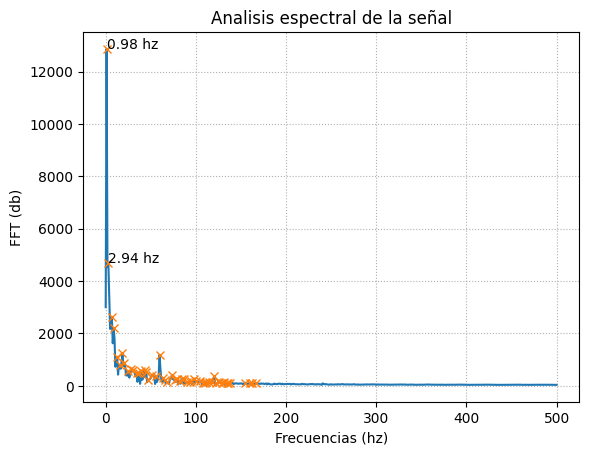

In [87]:
#FFT
N=2**10 # 10 bits

X3 = np.fft.fft(senaluV,N)
X3 = X3[0:N//2]
X3m = np.abs(X3)
F = np.linspace(0,Fs/2,N//2)

plt.plot(F, X3m)
plt.grid(linestyle=":")
plt.title("Analisis espectral de la señal")
plt.xlabel("Frecuencias (hz)")
plt.ylabel("FFT (db)")

peaks, properties = signal.find_peaks(X3m, height=100)
plt.plot(F[peaks],properties["peak_heights"],"x")
plt.text(F[peaks][0],properties["peak_heights"][0], f"{np.round(F[peaks][0],2)} hz")
plt.text(F[peaks][1],properties["peak_heights"][1], f"{np.round(F[peaks][1],2)} hz")

plt.show()

Cálculo de orden y frecuencia de corte

In [88]:
wp=2*np.pi*30
ws=2*np.pi*55

N_ord, Wc= signal.buttord(wp, ws, gpass=3, gstop=40, analog=True) #gpass=loss in passband edge frecuencies, gstop= attenuation in stopband edge frecuencies
fc = np.round(Wc/(2*np.pi) ,2)

print(f"Orden del filtro: {N_ord}")
print(f"Frecuencia de corte calculada: {fc} hz")


Orden del filtro: 8
Frecuencia de corte calculada: 30.01 hz


In [89]:
# Funcion de transferencia del filtro pasa bajo analogico
b,a = signal.butter(N_ord, Wc, 'lowpass', True, 'ba')

#np.set_printoptions(precision=3)
b,a

(array([1.59749756e+18]),
 array([1.00000000e+00, 9.66483179e+02, 4.67044868e+05, 1.46441783e+08,
        3.24680654e+10, 5.20625048e+12, 5.90308051e+14, 4.34284624e+16,
        1.59749756e+18]))

**Respuesta en frecuencia del filtro**

Text(0, 0.5, 'Magnitud (db)')

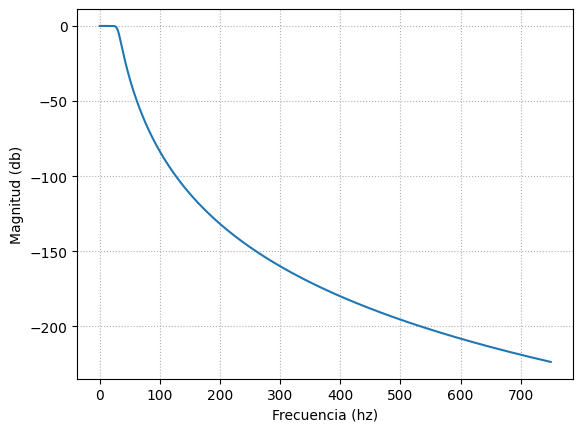

In [90]:
# Respuesta en frecuencia del filtro analogico
Fmax=750
F_freqs = np.linspace(0,Fmax,1000)
W_freqs = 2*np.pi*F_freqs  #Angular frecuences

W_freqs, H = signal.freqs(b,a,W_freqs)
Hm=np.abs(H)
plt.plot(F_freqs, 20 * np.log10(Hm))
plt.grid(linestyle=":")
plt.xlabel("Frecuencia (hz)")
plt.ylabel("Magnitud (db)")

**Transformación billinear**

Text(0, 0.5, 'Magnitud (db)')

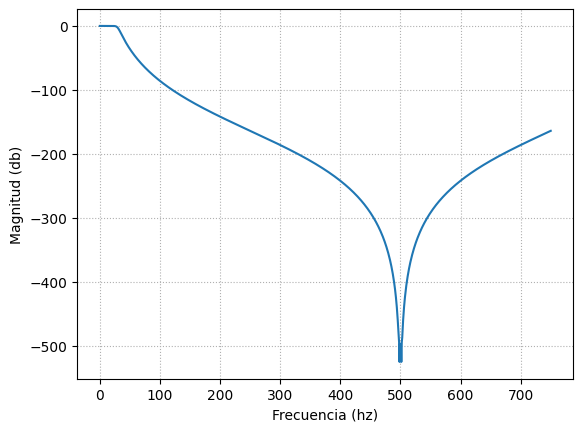

In [91]:
bd, ad = signal.bilinear(b,a,Fs)

Wz, Hd = signal.freqz(bd, ad, W_freqs/Fs)

Hdm = np.abs(Hd)
plt.plot(F_freqs, 20 * np.log10(Hdm))
plt.grid(linestyle=":")
plt.xlabel("Frecuencia (hz)")
plt.ylabel("Magnitud (db)")

**Aplicación del filtro**

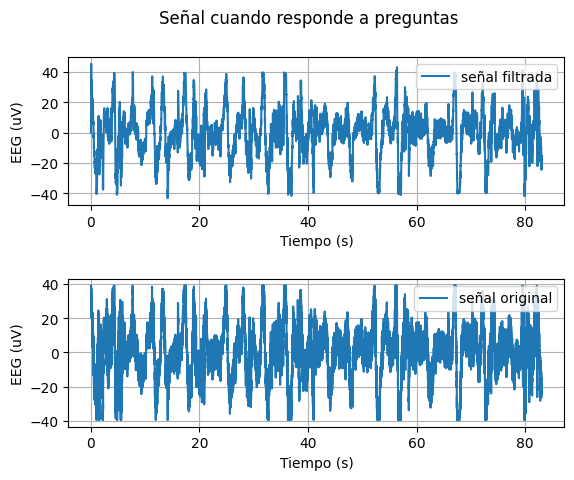

In [92]:
y = signal.lfilter(bd,ad, senaluV)
fig, ax = plt.subplots(2,1)
ax[0].plot(t,y, label="señal filtrada")
ax[0].legend(loc="upper right")
ax[0].grid()
ax[0].set_ylabel("EEG (uV)")
ax[0].set_xlabel("Tiempo (s)")
ax[1].plot(t,senaluV, label="señal original")
ax[1].legend(loc="upper right")
ax[1].grid()
ax[1].set_xlabel("Tiempo (s)")
ax[1].set_ylabel("EEG (uV)")
plt.subplots_adjust(hspace=0.5)
#fig.suptitle("Señal basal")
#fig.suptitle('Señal cuando pestañea') #título
fig.suptitle('Señal cuando responde a preguntas') #título
plt.show()

Verificando el efecto del filtro en la frecuencia de la señal:

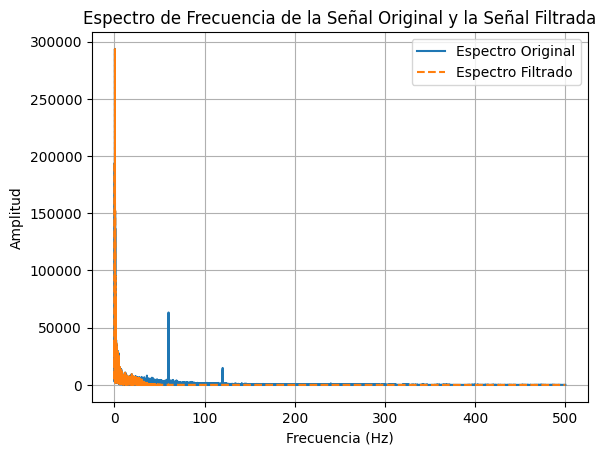

In [95]:
# Calcular la FFT de la señal original y la señal filtrada
fft_senal = np.fft.fft(senaluV)
fft_senal_filtrada = np.fft.fft(y)

# Definir las frecuencias
frequencies = np.fft.fftfreq(len(senal), 1/Fs)

# Graficar el espectro de frecuencia
plt.figure()
plt.plot(frequencies[:len(frequencies)//2], np.abs(fft_senal)[:len(frequencies)//2], label='Espectro Original')
plt.plot(frequencies[:len(frequencies)//2], np.abs(fft_senal_filtrada)[:len(frequencies)//2], label='Espectro Filtrado', linestyle='--')
plt.title('Espectro de Frecuencia de la Señal Original y la Señal Filtrada')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Amplitud')
plt.legend()
plt.grid()
plt.show()